# 05- Acoustic modeling with the first order velocity formulation


In this tutorial, we introduce the use of staggered grid to solve the first order acoustic wave equation that couples a vectorial particle velocity and a scalar Pressure.


## Model

We start, as in the previous tutorials, by setting up a Grid .

In [1]:
from devito import *
from seismic.source import WaveletSource, TimeAxis
from seismic import plot_image
import numpy as np

from sympy import init_printing, latex
init_printing(use_latex='mathjax')

In [2]:
# Initial grid: 1km x 1km, with spacing 100m
extent = (2000., 2000.)
shape = (81, 81)
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x, z))

## First order acoustic wave equation

The first order acoustic wave equation is defined as:

\begin{cases}
 & \frac{d p(t, x, y)}{dt}  = \lambda \nabla . v(t, x, y) \\
 & \frac{d v(t, x, y)}{dt} = \frac{1}{\rho} p(t, x, y)
\end{cases}

where $ p(t, x)$ is the pressure, $v(t, x, y) = (v_x(t, x, y), v_y(t, x, y)$ is the vector valued particle velocity and $\lambda, \rho$ are the first Lame parameter ($\lambda = \rho * v_p^2$ with $v_p$ the sound velocity) and the density.



In [3]:
class DGaussSource(WaveletSource):
    
    def wavelet(self, f0, t):
        a = 0.004
        return -2.*a*(t - 1./f0) * np.exp(-a * (t - 1./f0)**2)

# Timestep size from Eq. 7 with V_p=6000. and dx=100
t0, tn = 0., 200.
dt = 1e2*(1. / np.sqrt(2.)) / 60.
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = DGaussSource(name='src', grid=grid, f0=0.01, time_range=time_range)
src.coordinates.data[:] = [1000., 1000.]

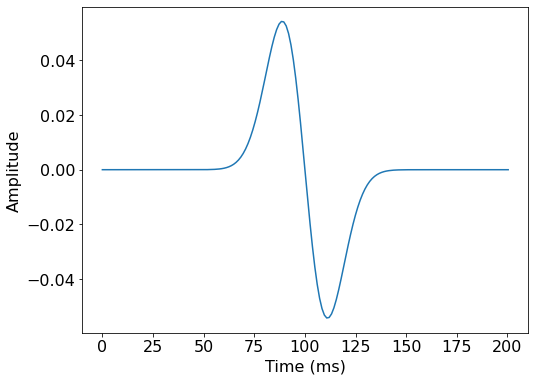

In [4]:
#NBVAL_SKIP

src.show()

In [5]:
# Now we create the velocity and pressure fields
p = TimeFunction(name='p', grid=grid, staggered=NODE, space_order=2, time_order=1)
v = VectorTimeFunction(name='v', grid=grid, space_order=2, time_order=1)

In [6]:
from devito.finite_differences.operators import div, grad
t = grid.stepping_dim
time = grid.time_dim

# We need some initial conditions
V_p = 4.0
density = 1.

ro = 1/density * dt
l2m = V_p*V_p*density * dt

# The source injection term
src_p = src.inject(field=p.forward, expr=src)

# 2nd order acoustic according to fdelmoc
u_v_2 = Eq(v.forward, v + ro * grad(p))
u_p_2 = Eq(p.forward, p + l2m * div(v.forward))

In [7]:
u_v_2

Eq(Vector(v_x(t + dt, x + h_x/2, z), v_z(t + dt, x, z + h_z/2)), Vector(v_x(t, x + h_x/2, z) + 1.17851130197758*Derivative(p(t, x, z), x), v_z(t, x, z + h_z/2) + 1.17851130197758*Derivative(p(t, x, z), z)))

In [8]:
u_p_2

Eq(p(t + dt, x, z), p(t, x, z) + 18.8561808316413*Derivative(v_x(t + dt, x + h_x/2, z), x) + 18.8561808316413*Derivative(v_z(t + dt, x, z + h_z/2), z))

In [9]:
op_2 = Operator([u_v_2, u_p_2] + src_p)

In [10]:
#NBVAL_IGNORE_OUTPUT

# Propagate the source
op_2(time=src.time_range.num-1)

Operator `Kernel` run in 0.07 s


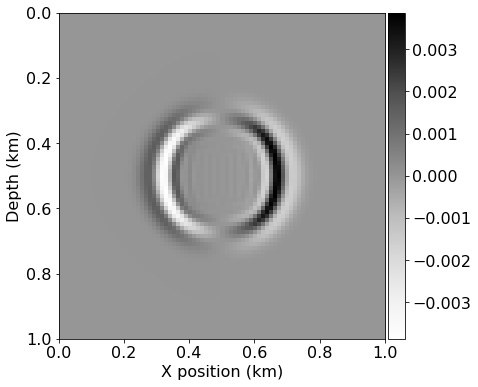

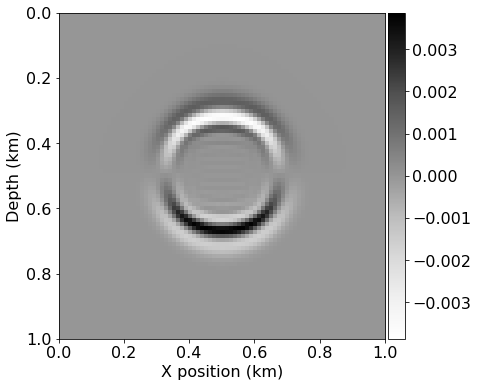

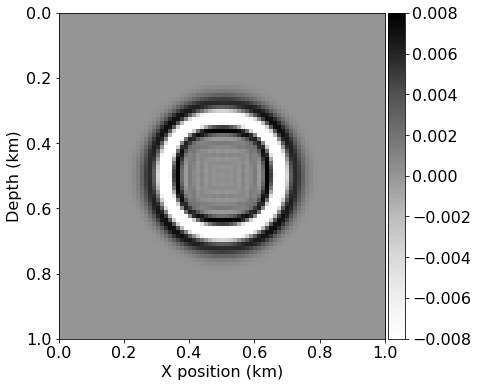

In [11]:
#NBVAL_SKIP

# Let's see what we got....
plot_image(v[0].data[0])
plot_image(v[1].data[0])
plot_image(p.data[0])

In [12]:
norm_p = norm(p)
assert np.isclose(norm_p, .35098, atol=1e-4, rtol=0)

## High order FD

Similarly to the acoustic and scalar case, Devito handles any spatial discretization order trivially with a simple change at the `Function` definitio. We now compute the acoustic fields with a fourth order finite-difference scheme that will be less dispersive.

In [13]:
# # 4th order acoustic according to fdelmoc
# # Now we create the velocity and pressure fields
p4 = TimeFunction(name='p', grid=grid, staggered=NODE, space_order=4, time_order=1)
v4 = VectorTimeFunction(name='v', grid=grid, space_order=4, time_order=1)
u_v_4 = Eq(v4.forward, v4 + ro * grad(p4))
u_p_4 = Eq(p4.forward, p4 + l2m * div(v4.forward))

In [14]:
#NBVAL_IGNORE_OUTPUT
op_4 = Operator([u_v_4, u_p_4] + src_p)
# Propagate the source
op_4(time=src.time_range.num-1)

Operator `Kernel` run in 0.01 s


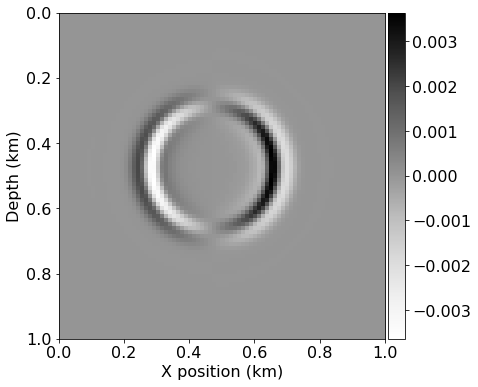

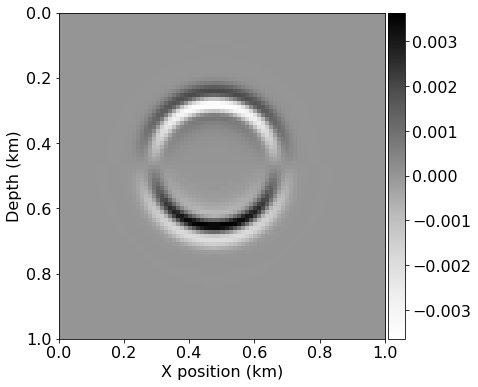

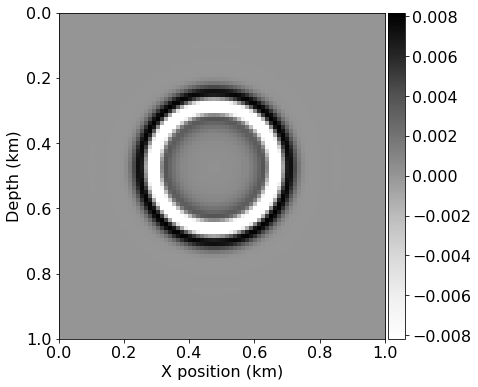

In [15]:
#NBVAL_SKIP

# Let's see what we got....
plot_image(v4[0].data[-1])
plot_image(v4[1].data[-1])
plot_image(p4.data[-1])

In [16]:
norm_p = norm(p)
assert np.isclose(norm_p, .35098, atol=1e-4, rtol=0)